# MediaPipe EyeBlink Detection

## Configuration

In [ ]:
!wget -O configure.sh 'https://raw.githubusercontent.com/sawthiha/pymp_proctor/master/configure.sh'
!chmod +x configure.sh
!./configure.sh

--2022-10-14 09:05:06--  https://raw.githubusercontent.com/sawthiha/pymp_proctor/master/configure.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 744 [text/plain]
Saving to: ‘configure.sh’

configure.sh        100%[===================>]     744  --.-KB/s    in 0s      

2022-10-14 09:05:07 (41.4 MB/s) - ‘configure.sh’ saved [744/744]

--2022-10-14 09:05:07--  https://zenodo.org/record/2529036/files/s000_noglasses.tar?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 798545920 (762M) [application/octet-stream]
Saving to: ‘dataset/rt_bene/archive/s000_ng.tar’

dataset/rt_bene/arc 100%[===================>] 761.55M  23

## Dependencies

In [ ]:
!pip install mediapipe

import mediapipe as mp
import cv2
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import sklearn.metrics as metrics

import statsmodels.formula.api as smf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.5 MB 166 kB/s 


## Constant and Helpers

In [ ]:
landmark_indices = [
    # left_iris
    469, 470,
    471, 472,
    
    # right iris
    474, 475,
    476, 477,

    # nose
    1,

    # left eye, right to left
    158, 159, 160,
    153, 145, 144,
    # left eye left - right
    33, 133, 

    # right eye, right to left
    387, 386, 385,
    373, 374, 380,
    # right eye left - right
    362, 263
]
coor_columns = [item for sublist in [(f'{idx}_x', f'{idx}_y') for idx in landmark_indices] for item in sublist]

In [ ]:
def read_blink_df(id: int) -> pd.DataFrame:
  blink_df = pd.read_csv(f'dataset/rt_bene/raw/s{id:03}_noglasses/blink_labels.csv', names=['image', 'is_blinking'])
  blink_df.image = blink_df.image.str.replace('left', f'dataset/rt_bene/raw/s{id:03}_noglasses/natural/face/face')
  return blink_df

In [ ]:
def infer_static_images(images, callback):
  N_IMAGES = len(images)
  na_idx = []
  mp_face_mesh = mp.solutions.face_mesh
  with mp_face_mesh.FaceMesh(
      static_image_mode=True,
      max_num_faces=1,
      refine_landmarks=True,
      min_detection_confidence=0.5) as face_mesh:
    for idx, file in enumerate(images):
      print(f'{idx / N_IMAGES * 100}% analyzed', end = '\r')
      image = cv2.imread(file)
      # Convert the BGR image to RGB before processing.
      try:
        res = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      except:
        na_idx.append(idx)
        print(f'Exception occured while processing {file} at index {idx}')
        continue
      
      # Print and draw face mesh landmarks on the image.
      if not res.multi_face_landmarks:
        na_idx.append(idx)
        continue
      callback(idx, image, res.multi_face_landmarks)     
  return na_idx

def record_coor_df_decorator(coor_df):
  def wrapper(idx, image, multi_face_landmarks):
    for face_landmarks in multi_face_landmarks:
        ls = face_landmarks
        xs = [landmark.x for landmark in face_landmarks.landmark]
        ys = [landmark.y for landmark in face_landmarks.landmark]
        zs = [landmark.z for landmark in face_landmarks.landmark]
        xs = np.array(xs)
        ys = np.array(ys)
        zs = np.array(zs)
        std_xs = (xs - xs.mean()) / xs.std()
        std_ys = (ys - ys.mean()) / ys.std()
        std_zs = (zs - zs.mean()) / zs.std()

        for lm_idx in landmark_indices:
          coor_df.loc[idx, f'{lm_idx}_x'] = std_xs[lm_idx]
          coor_df.loc[idx, f'{lm_idx}_y'] = std_ys[lm_idx]
  return wrapper

def record_candid_coor_df_decorator(coor_df):
  def wrapper(idx, image, multi_face_landmarks):
    width = image.shape[0]
    height = image.shape[1]
    for face_landmarks in multi_face_landmarks:
        ls = face_landmarks
        xs = [landmark.x for landmark in face_landmarks.landmark]
        ys = [landmark.y for landmark in face_landmarks.landmark]
        zs = [landmark.z for landmark in face_landmarks.landmark]
        xs = np.array(xs)
        ys = np.array(ys)
        zs = np.array(zs)
        candid_xs = xs * width
        candid_ys = ys * height
        candid_zs = zs

        for lm_idx in landmark_indices:
          coor_df.loc[idx, f'{lm_idx}_x'] = candid_xs[lm_idx]
          coor_df.loc[idx, f'{lm_idx}_y'] = candid_ys[lm_idx]
  return wrapper

def annotate_static_images(images, callback):
  mp_drawing = mp.solutions.drawing_utils
  mp_drawing_styles = mp.solutions.drawing_styles
  mp_face_mesh = mp.solutions.face_mesh

  # For static images:
  IMAGE_FILES = images
  blinks = []
  with mp_face_mesh.FaceMesh(
      static_image_mode=True,
      max_num_faces=1,
      refine_landmarks=True,
      min_detection_confidence=0.5) as face_mesh:
    for idx, file in enumerate(IMAGE_FILES):
      image = cv2.imread(file)
      # Convert the BGR image to RGB before processing.
      results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      # Print and draw face mesh landmarks on the image.
      if not results.multi_face_landmarks:
        continue
      annotated_image = image.copy()
      for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_iris_connections_style())
      callback(idx, annotated_image)

## Prepare Training Data

In [ ]:
train_blink_df = pd.concat(
    [read_blink_df(id) for id in range(14)]
)

train_coor_df = pd.DataFrame(
    data = {
        col: np.zeros(train_blink_df.shape[0])
        for col in coor_columns
    }, 
)

na_idx = infer_static_images(train_blink_df.image.to_list(), record_coor_df_decorator(train_coor_df))
train_blink_df[train_coor_df.columns] = train_coor_df
train_blink_df = train_blink_df.drop(train_blink_df.index[na_idx])
train_blink_df.to_csv('train_rtbene_coors.csv')

Exception occured while processing dataset/rt_bene/raw/s012_noglasses/natural/face/face_000234_rgb.png at index 98185
Exception occured while processing dataset/rt_bene/raw/s012_noglasses/natural/face/face_000235_rgb.png at index 98186
Exception occured while processing dataset/rt_bene/raw/s012_noglasses/natural/face/face_000236_rgb.png at index 98187
Exception occured while processing dataset/rt_bene/raw/s012_noglasses/natural/face/face_000237_rgb.png at index 98188
Exception occured while processing dataset/rt_bene/raw/s012_noglasses/natural/face/face_000303_rgb.png at index 98189
Exception occured while processing dataset/rt_bene/raw/s012_noglasses/natural/face/face_000304_rgb.png at index 98190
Exception occured while processing dataset/rt_bene/raw/s012_noglasses/natural/face/face_000305_rgb.png at index 98191
Exception occured while processing dataset/rt_bene/raw/s012_noglasses/natural/face/face_000306_rgb.png at index 98192
Exception occured while processing dataset/rt_bene/raw/s

In [ ]:
train_blink_df = pd.concat(
    [read_blink_df(id) for id in range(14)]
)

train_coor_df = pd.DataFrame(
    data = {
        col: np.zeros(train_blink_df.shape[0])
        for col in coor_columns
    }, 
)

na_idx = infer_static_images(train_blink_df.image.to_list(), record_candid_coor_df_decorator(train_coor_df))
train_blink_df[train_coor_df.columns] = train_coor_df
train_blink_df = train_blink_df.drop(train_blink_df.index[na_idx])
train_blink_df.to_csv('train_rtbene_candid_coors.csv')

Exception occured while processing dataset/rt_bene/raw/s012_noglasses/natural/face/face_000234_rgb.png at index 98185
Exception occured while processing dataset/rt_bene/raw/s012_noglasses/natural/face/face_000235_rgb.png at index 98186
Exception occured while processing dataset/rt_bene/raw/s012_noglasses/natural/face/face_000236_rgb.png at index 98187
Exception occured while processing dataset/rt_bene/raw/s012_noglasses/natural/face/face_000237_rgb.png at index 98188
Exception occured while processing dataset/rt_bene/raw/s012_noglasses/natural/face/face_000303_rgb.png at index 98189
Exception occured while processing dataset/rt_bene/raw/s012_noglasses/natural/face/face_000304_rgb.png at index 98190
Exception occured while processing dataset/rt_bene/raw/s012_noglasses/natural/face/face_000305_rgb.png at index 98191
Exception occured while processing dataset/rt_bene/raw/s012_noglasses/natural/face/face_000306_rgb.png at index 98192
Exception occured while processing dataset/rt_bene/raw/s

## Prepare Evaluation Data

In [ ]:
eval_blink_df = pd.concat(
    [read_blink_df(id) for id in range(14, 17)]
)
eval_coor_df = pd.DataFrame(
    data = {
        col: np.zeros(eval_blink_df.shape[0])
        for col in coor_columns
    }, 
)
na_idx = infer_static_images(eval_blink_df.image.to_list(), record_coor_df_decorator(eval_coor_df))
eval_blink_df[eval_coor_df.columns] = eval_coor_df
eval_blink_df = eval_blink_df.drop(eval_blink_df.index[na_idx])
eval_blink_df.to_csv('test_rtbene_coors.csv')

In [ ]:
eval_blink_df = pd.concat(
    [read_blink_df(id) for id in range(14, 17)]
)
eval_coor_df = pd.DataFrame(
    data = {
        col: np.zeros(eval_blink_df.shape[0])
        for col in coor_columns
    }, 
)
na_idx = infer_static_images(eval_blink_df.image.to_list(), record_candid_coor_df_decorator(eval_coor_df))
eval_blink_df[eval_coor_df.columns] = eval_coor_df
eval_blink_df = eval_blink_df.drop(eval_blink_df.index[na_idx])
eval_blink_df.to_csv('test_rtbene_candid_coors.csv')

## AD Hoc blink regression

In [ ]:
# threshold = std_xs[1] * 0.0308 + std_ys[1] * 0.0803 + 0.1476

## Read Training data and Evaluation Data

In [ ]:
train_df = pd.read_csv('train_rtbene_coors.csv', index_col = 0)
train_blinking_df = train_df[train_df.is_blinking == 1.0]
eval_df = pd.read_csv('test_rtbene_coors.csv', index_col = 0)

## Eye Lid Distance Models

### Helpers

In [ ]:
def get_point(df, point):
  return df[[f'{point}_x', f'{point}_y']]

def get_distance(df, p1, p2):
  return np.sqrt(np.square(get_point(df, p1).to_numpy() - get_point(df, p2).to_numpy()).sum(axis = 1))

def draw_stats_result(df, data, results, control_var):
  crit = 1 - (95 / 100)
  df = df.shape[0] - 2
  margin_error = scipy.stats.t.ppf(crit, df) * results.bse[0]

  fig, axes = plt.subplots(ncols = 2, figsize = (20, 10))
  axes = axes.flatten()
  predicted_data = data
  predicted_data['predicted'] = results.predict(data)

  print(results.params[0] + margin_error)
  predicted_data['upper_predicted'] = (results.params[0] + margin_error) * data['nose_y']

  sns.scatterplot(data = predicted_data, x = 'nose_x', y = control_var, ax = axes[0])
  sns.scatterplot(data = predicted_data, x = 'nose_x', y = 'predicted', ax = axes[0])
  # sns.scatterplot(data = predicted_data, x = 'nose_x', y = 'upper_predicted', ax = axes[0])
  sns.scatterplot(data = data, x = 'nose_y', y = control_var, ax = axes[1])
  sns.scatterplot(data = predicted_data, x = 'nose_y', y = 'predicted', ax = axes[1])

In [ ]:
def evaluate_dist_ols_results(results):
  eval_blinking_df = eval_df[eval_df.is_blinking == 1.0]
  eval_eyelid_dist = np.sqrt(np.square(get_point(eval_blinking_df, 159).to_numpy() - get_point(eval_blinking_df, 145).to_numpy()).sum(axis = 1))
  eval_nose_coor = get_point(eval_blinking_df, 1)
  data = pd.DataFrame(
      data = {
          'eyelid_dist': eval_eyelid_dist,
          'nose_x': eval_nose_coor[eval_nose_coor.columns[0]],
          'nose_y': eval_nose_coor[eval_nose_coor.columns[1]],
      }
  )
  y_cap = results.predict(data)
  mae = metrics.mean_squared_error(data['eyelid_dist'], y_cap)
  print(f'Mean Squared Error of Threshold Regression: {mae}')
  eval_eyelid_dist = np.sqrt(np.square(get_point(eval_df, 159).to_numpy() - get_point(eval_df, 145).to_numpy()).sum(axis = 1))
  eval_nose_coor = get_point(eval_df, 1)
  eval_data = pd.DataFrame(
      data = {
          'eyelid_dist': eval_eyelid_dist,
          'nose_x': eval_nose_coor[eval_nose_coor.columns[0]],
          'nose_y': eval_nose_coor[eval_nose_coor.columns[1]],
      }
  )
  eval_data['threshold'] = results.predict(eval_data)
  eval_data['is_blinking'] = (eval_data.eyelid_dist < (eval_data.threshold)).astype(float) 
  valid_idx = eval_df['is_blinking'] != 0.5
  return eval_df[valid_idx].is_blinking, eval_data[valid_idx].is_blinking

def draw_dist_ols_confusion(results):
  labels = [0.0, 1.0]
  labels_2 = ['no blink', 'blink']
  y, y_cap = evaluate_dist_ols_results(results)

  print(f'F1 Score: {metrics.f1_score(y, y_cap)}')
  print(f'Accuracy: {metrics.accuracy_score(y, y_cap)}')
  print(f'ROC AUC Score: {metrics.roc_auc_score(y, y_cap)}')

  cf_matrix = metrics.confusion_matrix(y, y_cap, labels = labels)
  ax = sns.heatmap(cf_matrix, annot=True, 
              fmt='2', cmap='Blues')

  ax.set_title('Confusion Matrix for predicted CMU face dataset alignments\n\n');
  ax.set_xlabel('\nPredicted Alignment')
  ax.set_ylabel('Actual Alignment');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(labels_2)
  ax.yaxis.set_ticklabels(labels_2)

### Orientation and Eye Lid Closeness on Training Data

In [ ]:
train_eyelid_dist = np.sqrt(np.square(get_point(train_blinking_df, 159).to_numpy() - get_point(train_blinking_df, 145).to_numpy()).sum(axis = 1))
train_nose_coor = get_point(train_blinking_df, 1)
data = pd.DataFrame(
    data = {
        'eyelid_dist_threshold': train_eyelid_dist,
        'nose_x': train_nose_coor[train_nose_coor.columns[0]],
        'nose_y': train_nose_coor[train_nose_coor.columns[1]],
    }
)

#### OLS Regression, eyelid_dist ~ nose_y - 1

0.4115356969494218


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
=====================================================================================
Model:                  OLS                   Adj. R-squared (uncentered): 0.818     
Dependent Variable:     eyelid_dist_threshold AIC:                         -8250.1402
Date:                   2022-08-13 12:08      BIC:                         -8243.6975
No. Observations:       4641                  Log-Likelihood:              4126.1    
Df Model:               1                     F-statistic:                 2.091e+04 
Df Residuals:           4640                  Prob (F-statistic):          0.00      
R-squared (uncentered): 0.818                 Scale:                       0.0098947 
-------------------------------------------------------------------------------------------
                Coef.        Std.Err.          t           P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------------
nose_y          0.4163         0.0029       144.5891       0.0000       0.4106       0.4219
-------------------------------------------------------------------------------------
Omnibus:                   3202.033             Durbin-Watson:                0.115  
Prob(Omnibus):             0.000                Jarque-Bera (JB):             347.194
Skew:                      -0.324               Prob(JB):                     0.000  
Kurtosis:                  1.828                Condition No.:                1      
=====================================================================================

"""

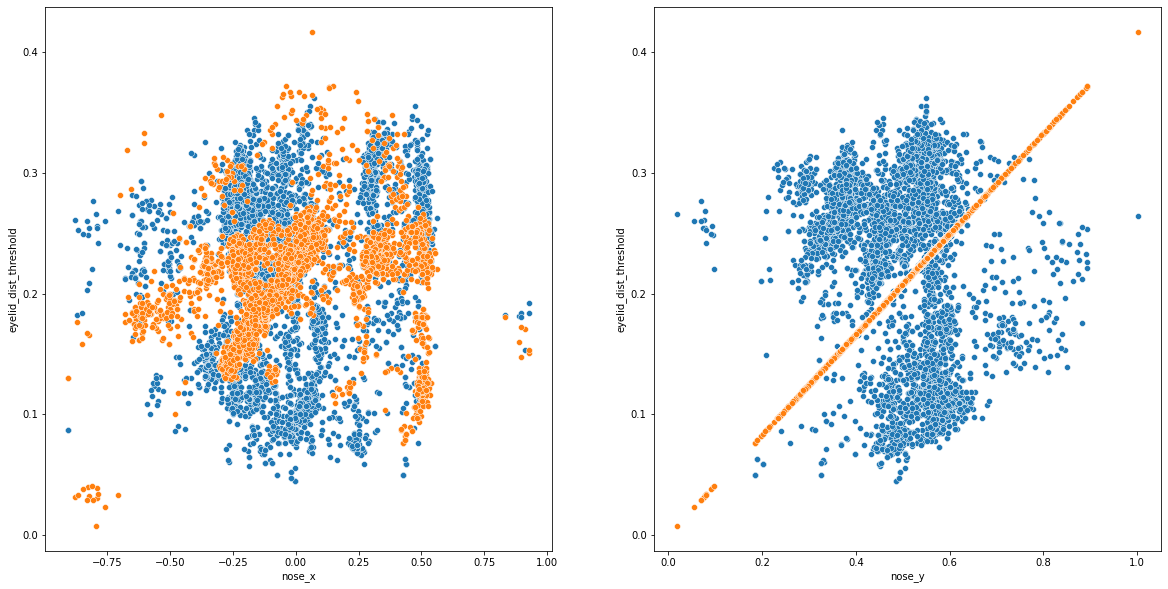

In [ ]:
results = smf.ols('eyelid_dist_threshold ~ nose_y - 1', data = data).fit()
draw_stats_result(train_blinking_df, data, results, 'eyelid_dist_threshold')
results.summary2()

Mean Squared Error of Threshold Regression: 0.01235888133839547
F1 Score: 0.3744292237442922
Accuracy: 0.9648807997949244
ROC AUC Score: 0.7041739682757463


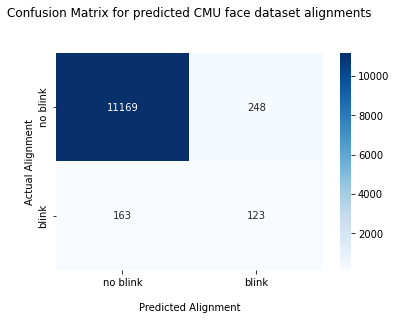

In [ ]:
draw_dist_ols_confusion(results)

#### OLS Regression, eyelid_dist ~ nose_x + nose_y - 1

0.3174590301747599


<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
=========================================================================
Model:              OLS                   Adj. R-squared:     0.097      
Dependent Variable: eyelid_dist_threshold AIC:                -11212.3335
Date:               2022-08-13 12:09      BIC:                -11193.0055
No. Observations:   4641                  Log-Likelihood:     5609.2     
Df Model:           2                     F-statistic:        248.9      
Df Residuals:       4638                  Prob (F-statistic): 2.12e-103  
R-squared:          0.097                 Scale:              0.0052242  
----------------------------------------------------------------------------
              Coef.     Std.Err.       t        P>|t|      [0.025     0.975]
----------------------------------------------------------------------------
Intercept     0.3258      0.0051     64.4199    0.0000     0.3159     0.3357
nose_x        0.0409      0.0040     10.3183    0.0000     0.0332     0.0487
nose_y       -0.2099      0.0099    -21.1109    0.0000    -0.2294    -0.1904
-------------------------------------------------------------------------
Omnibus:                319.071         Durbin-Watson:            0.195  
Prob(Omnibus):          0.000           Jarque-Bera (JB):         226.170
Skew:                   -0.435          Prob(JB):                 0.000  
Kurtosis:               2.357           Condition No.:            12     
=========================================================================

"""

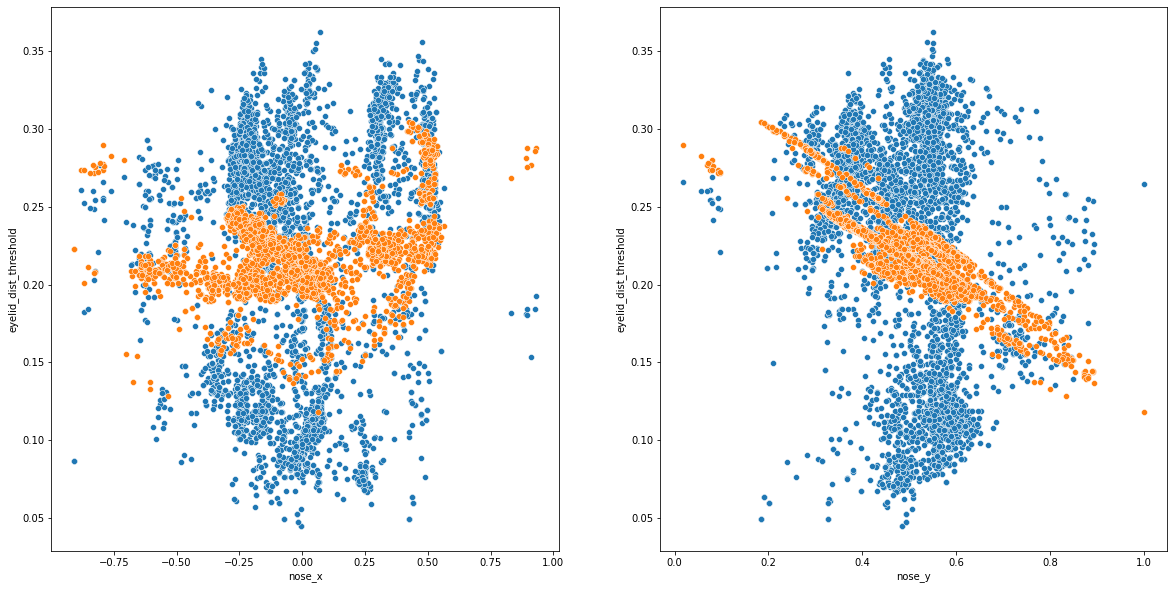

In [ ]:
results = smf.ols('eyelid_dist_threshold ~ nose_x + nose_y', data = data).fit()
draw_stats_result(train_blinking_df, data, results, 'eyelid_dist_threshold')
results.summary2()

Mean Squared Error of Threshold Regression: 0.030478470932189018
F1 Score: 0.04961460086825551
Accuracy: 0.08339741946509442
ROC AUC Score: 0.5199913513831356


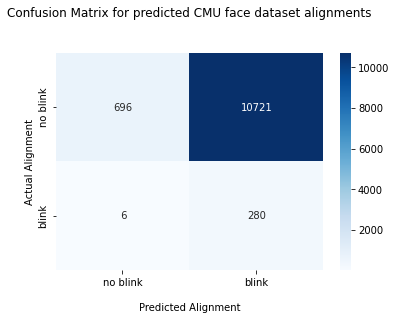

In [ ]:
draw_dist_ols_confusion(results)

#### GLM Regression, eyelid_dist ~ nose_y - 1

0.4115356969494218


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Generalized linear model
=====================================================================
Model:              GLM                   AIC:            -8250.1402 
Link Function:      identity              BIC:            -39128.1477
Dependent Variable: eyelid_dist_threshold Log-Likelihood: 4126.1     
Date:               2022-08-13 12:10      LL-Null:        5090.3     
No. Observations:   4641                  Deviance:       45.911     
Df Model:           0                     Pearson chi2:   45.9       
Df Residuals:       4640                  Scale:          0.0098947  
Method:             IRLS                                             
------------------------------------------------------------------------
            Coef.     Std.Err.       z        P>|z|     [0.025    0.975]
------------------------------------------------------------------------
nose_y      0.4163      0.0029    144.5891    0.0000    0.4106    0.4219
=====================================================================

"""

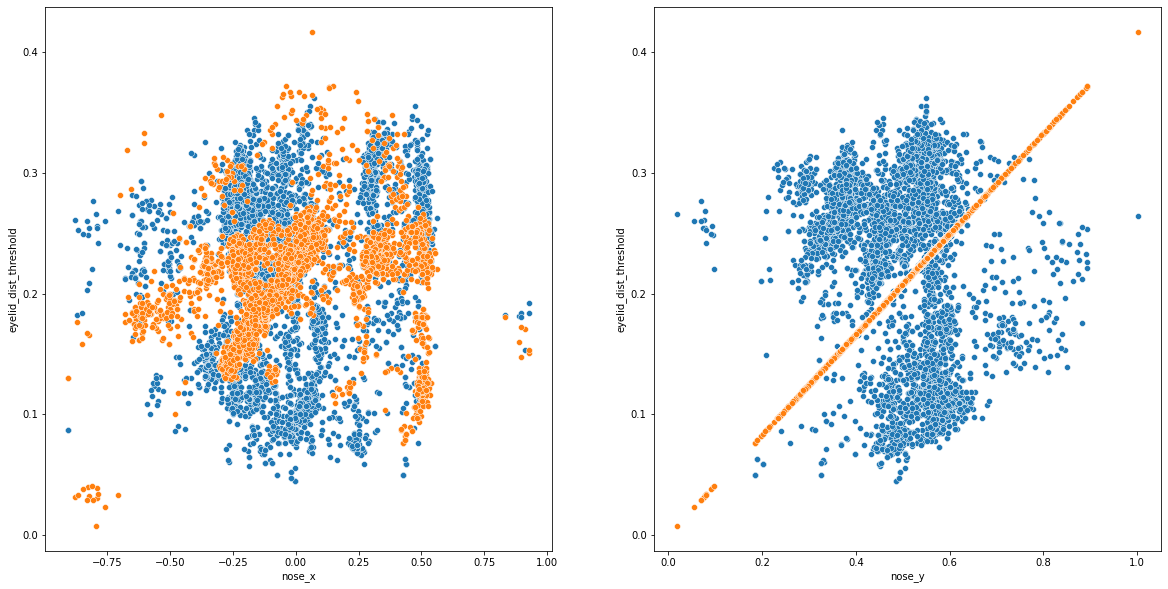

In [ ]:
results = smf.glm('eyelid_dist_threshold ~ nose_y - 1', data = data).fit()
draw_stats_result(train_blinking_df, data, results, 'eyelid_dist_threshold')
results.summary2()

Mean Squared Error of Threshold Regression: 0.01235888133839547
F1 Score: 0.3744292237442922
Accuracy: 0.9648807997949244
ROC AUC Score: 0.7041739682757463


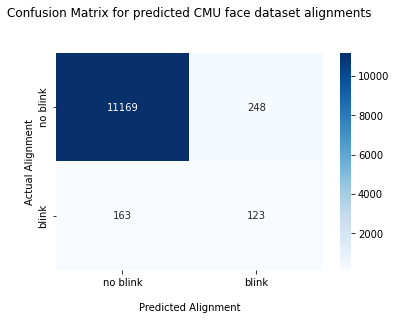

In [ ]:
draw_dist_ols_confusion(results)

## Eye Aspect Ratio (EAR) Models

In [ ]:
def eval_ear(df):
  vert_1 = get_distance(df, 158, 153)
  vert_2 = get_distance(df, 160, 144)
  hor = get_distance(df, 33, 133)
  eye_aspect = (vert_1 + vert_2) / (2 * hor)
  nose_coors = get_point(df, 1)
  data = pd.DataFrame(
      data = {
          'ear_threshold': eye_aspect,
          'nose_x': nose_coors[nose_coors.columns[0]],
          'nose_y': nose_coors[nose_coors.columns[1]],
      }
  )
  return data

def draw_ear_ols_confusion(results):
  eval_data = eval_ear(eval_df)
  eval_data['threshold'] = results.predict(eval_data)
  eval_data['is_blinking'] = (eval_data.ear_threshold < (eval_data.threshold)).astype(float)
  valid_idx = eval_df['is_blinking'] != 0.5
  # metrics.confusion_matrix(eval_processed_df[valid_idx].is_blinking, eval_data[valid_idx].is_blinking, labels = [0.0, 1.0])
  labels = [0.0, 1.0]
  labels_2 = ['no blink', 'blink']
  y, y_cap = eval_df[valid_idx].is_blinking, eval_data[valid_idx].is_blinking

  print(f'F1 Score: {metrics.f1_score(y, y_cap)}')
  print(f'Accuracy: {metrics.accuracy_score(y, y_cap)}')
  print(f'ROC AUC Score: {metrics.roc_auc_score(y, y_cap)}')

  cf_matrix = metrics.confusion_matrix(y, y_cap, labels = labels)
  ax = sns.heatmap(cf_matrix, annot=True, 
              fmt='2', cmap='Blues')

  ax.set_title('Confusion Matrix for predicted CMU face dataset alignments\n\n');
  ax.set_xlabel('\nPredicted Alignment')
  ax.set_ylabel('Actual Alignment');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(labels_2)
  ax.yaxis.set_ticklabels(labels_2)

### Orientation and EAR

0.41902421186529965


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.805     
Dependent Variable:     ear_threshold    AIC:                         -7640.4088
Date:                   2022-08-13 12:16 BIC:                         -7627.5234
No. Observations:       4641             Log-Likelihood:              3822.2    
Df Model:               2                F-statistic:                 9604.     
Df Residuals:           4639             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.805            Scale:                       0.011281  
-------------------------------------------------------------------------------------
             Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------
nose_y       0.4241        0.0031      137.6489      0.0000       0.4181       0.4301
nose_x      -0.0401        0.0057       -6.9775      0.0000      -0.0514      -0.0288
--------------------------------------------------------------------------------
Omnibus:                  109.707            Durbin-Watson:               0.112 
Prob(Omnibus):            0.000              Jarque-Bera (JB):            73.639
Skew:                     -0.188             Prob(JB):                    0.000 
Kurtosis:                 2.511              Condition No.:               2     
================================================================================

"""

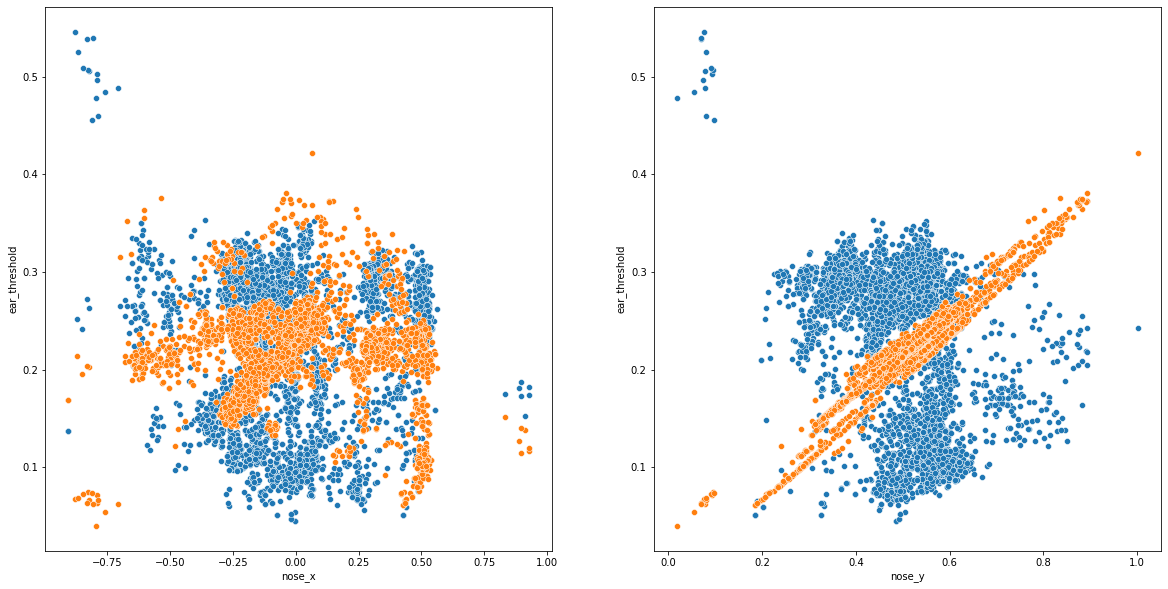

In [ ]:
train_data = eval_ear(train_blinking_df)
results = smf.ols('ear_threshold ~ nose_y + nose_x - 1', data = train_data).fit()
draw_stats_result(train_blinking_df, train_data, results, 'ear_threshold')
results.summary2()

F1 Score: 0.39741518578352186
Accuracy: 0.9681278304708194
ROC AUC Score: 0.7058381532630459


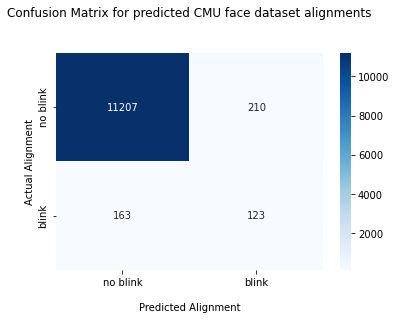

In [ ]:
draw_ear_ols_confusion(results)

### Constant Threshold

F1 Score: 0.24641148325358853
Accuracy: 0.892335298641374
ROC AUC Score: 0.8084625368500293


[Text(0, 0.5, 'no blink'), Text(0, 1.5, 'blink')]

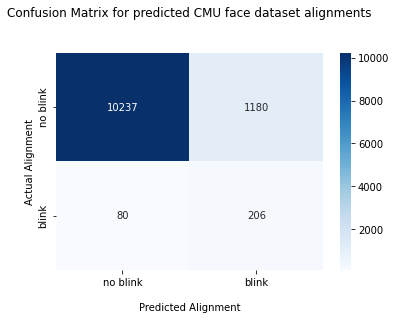

In [ ]:
eval_data = eval_ear(eval_df)
### Constant Threshold
eval_data['threshold'] = 0.2
eval_data['is_blinking'] = (eval_data.ear_threshold < (eval_data.threshold)).astype(float)
valid_idx = eval_df['is_blinking'] != 0.5

y, y_cap = eval_df[valid_idx].is_blinking, eval_data[valid_idx].is_blinking

print(f'F1 Score: {metrics.f1_score(y, y_cap)}')
print(f'Accuracy: {metrics.accuracy_score(y, y_cap)}')
print(f'ROC AUC Score: {metrics.roc_auc_score(y, y_cap)}')

# metrics.confusion_matrix(eval_processed_df[valid_idx].is_blinking, eval_data[valid_idx].is_blinking, labels = [0.0, 1.0])
labels = [0.0, 1.0]
labels_2 = ['no blink', 'blink']
cf_matrix = metrics.confusion_matrix(y, y_cap, labels = labels)
ax = sns.heatmap(cf_matrix, annot=True, 
            fmt='2', cmap='Blues')

ax.set_title('Confusion Matrix for predicted CMU face dataset alignments\n\n');
ax.set_xlabel('\nPredicted Alignment')
ax.set_ylabel('Actual Alignment');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(labels_2)
ax.yaxis.set_ticklabels(labels_2)

## Candid EAR

F1 Score: 0.24641148325358853
Accuracy: 0.892335298641374
ROC AUC Score: 0.8084625368500293


[Text(0, 0.5, 'no blink'), Text(0, 1.5, 'blink')]

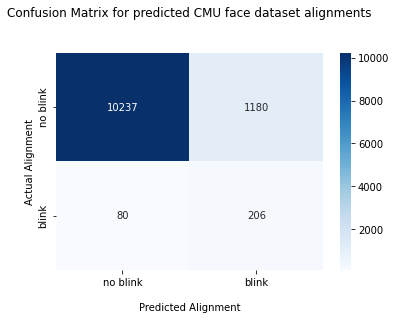

In [ ]:
train_df = pd.read_csv('train_rtbene_candid_coors.csv', index_col = 0)
train_blinking_df = train_df[train_df.is_blinking == 1.0]
eval_df = pd.read_csv('test_rtbene_candid_coors.csv', index_col = 0)

eval_data = eval_ear(eval_df)
eval_data['threshold'] = 0.2
eval_data['is_blinking'] = (eval_data.ear_threshold < (eval_data.threshold)).astype(float)
valid_idx = eval_df['is_blinking'] != 0.5

y, y_cap = eval_df[valid_idx].is_blinking, eval_data[valid_idx].is_blinking

print(f'F1 Score: {metrics.f1_score(y, y_cap)}')
print(f'Accuracy: {metrics.accuracy_score(y, y_cap)}')
print(f'ROC AUC Score: {metrics.roc_auc_score(y, y_cap)}')

# metrics.confusion_matrix(eval_processed_df[valid_idx].is_blinking, eval_data[valid_idx].is_blinking, labels = [0.0, 1.0])
labels = [0.0, 1.0]
labels_2 = ['no blink', 'blink']
cf_matrix = metrics.confusion_matrix(y, y_cap, labels = labels)
ax = sns.heatmap(cf_matrix, annot=True, 
            fmt='2', cmap='Blues')

ax.set_title('Confusion Matrix for predicted CMU face dataset alignments\n\n');
ax.set_xlabel('\nPredicted Alignment')
ax.set_ylabel('Actual Alignment');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(labels_2)
ax.yaxis.set_ticklabels(labels_2)


## Eyeblink8 and TalkingFace

In [1]:
# install imutils
!pip install imutils

!pip install mediapipe

# import packages
from scipy.spatial import distance as dist
import imutils
from imutils import face_utils
import numpy as np
np.random.seed(10)
import pandas as pd
import cv2
import os
import time
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, roc_auc_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

import mediapipe as mp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 23.1.21 which is incompatible.


In [ ]:
!mkdir -p input
!wget -O input/eyeblin8.zip https://www.blinkingmatters.com/files/upload/research/eyeblink8.zip
!wget -O input/talkingFace.zip https://www.blinkingmatters.com/files/upload/research/talkingFace.zip
!unzip -o input/talkingFace.zip -d input/
!unzip -o input/eyeblin8.zip -d input/

--2023-01-20 09:08:15--  https://www.blinkingmatters.com/files/upload/research/eyeblink8.zip
Resolving www.blinkingmatters.com (www.blinkingmatters.com)... 46.28.105.86, 2a02:2b88:1:4::38
Connecting to www.blinkingmatters.com (www.blinkingmatters.com)|46.28.105.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 312670860 (298M) [application/zip]
Saving to: ‘input/eyeblin8.zip’

input/eyeblin8.zip  100%[===================>] 298.19M  28.7MB/s    in 11s     

2023-01-20 09:08:26 (27.0 MB/s) - ‘input/eyeblin8.zip’ saved [312670860/312670860]

--2023-01-20 09:08:27--  https://www.blinkingmatters.com/files/upload/research/talkingFace.zip
Resolving www.blinkingmatters.com (www.blinkingmatters.com)... 46.28.105.86, 2a02:2b88:1:4::38
Connecting to www.blinkingmatters.com (www.blinkingmatters.com)|46.28.105.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21010855 (20M) [application/zip]
Saving to: ‘input/talkingFace.zip’

input/talkingFace.

In [ ]:
# print content of any folder
def display_folder(path):
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            print(os.path.join(dirname, filename))
# print content of "../input" folder
display_folder("./input")

./input/talkingFace.zip
./input/eyeblin8.zip
./input/talkingFace/talking.tag
./input/talkingFace/talking.avi
./input/talkingFace/talking.txt
./input/eyeblink8/11/27122013_154548_cam.tag
./input/eyeblink8/11/27122013_154548_cam.txt
./input/eyeblink8/11/27122013_154548_cam.avi
./input/eyeblink8/9/27122013_152435_cam.avi
./input/eyeblink8/9/27122013_152435_cam.txt
./input/eyeblink8/9/27122013_152435_cam.tag
./input/eyeblink8/3/26122013_230103_cam.tag
./input/eyeblink8/3/26122013_230103_cam.avi
./input/eyeblink8/3/26122013_230103_cam.txt
./input/eyeblink8/2/26122013_224532_cam.tag
./input/eyeblink8/2/26122013_224532_cam.txt
./input/eyeblink8/2/26122013_224532_cam.avi
./input/eyeblink8/10/27122013_153916_cam.tag
./input/eyeblink8/10/27122013_153916_cam.avi
./input/eyeblink8/10/27122013_153916_cam.txt
./input/eyeblink8/8/27122013_151644_cam.avi
./input/eyeblink8/8/27122013_151644_cam.txt
./input/eyeblink8/8/27122013_151644_cam.tag
./input/eyeblink8/1/26122013_223310_cam.txt
./input/eyeblink8

In [ ]:
def get_distance(p1, p2):
  return np.sqrt(np.square(p1 - p2).sum(axis = 0))

def eval_left_ear(landmarks):
  vert_1 = get_distance(landmarks[158], landmarks[153])
  vert_2 = get_distance(landmarks[160], landmarks[144])
  hor = get_distance(landmarks[33], landmarks[133])
  return (vert_1 + vert_2) / (2 * hor)

def eval_right_ear(landmarks):
  vert_1 = get_distance(landmarks[387], landmarks[373])
  vert_2 = get_distance(landmarks[385], landmarks[380])
  hor = get_distance(landmarks[362], landmarks[263])
  return (vert_1 + vert_2) / (2 * hor)

def eval_left_eld(landmarks):
  return get_distance(landmarks[159], landmarks[145])

def eval_right_eld(landmarks):
  return get_distance(landmarks[386], landmarks[374])

def eval_face_orientation(landmarks):
  return landmarks[1][0], landmarks[1][1]

def landmarks_decor(func):
  def wrapper(landmarks, width, height):
    landmarks = landmarks.landmark
    xs = np.array([landmark.x for landmark in landmarks])
    ys = np.array([landmark.y for landmark in landmarks])
    zs = np.array([landmark.z for landmark in landmarks])
    return func(xs, ys, zs, width, height)
  return wrapper

@landmarks_decor
def candid_ear_model(xs, ys, zs, width, height):
  candid_xs = xs * width
  candid_ys = ys * height
  landmarks = np.stack([candid_xs, candid_ys], axis = 1)
  leftEAR = eval_left_ear(landmarks)
  rightEAR = eval_right_ear(landmarks)
  ear = (leftEAR + rightEAR) / 2.0
  return int(ear < 0.2), int(leftEAR < 0.2), int(rightEAR < 0.2), ear, leftEAR, rightEAR

@landmarks_decor
def adaptive_eld_model(xs, ys, zs, _, __):
  std_xs = (xs - xs.mean()) / xs.std()
  std_ys = (ys - ys.mean()) / ys.std()
  std_zs = (zs - zs.mean()) / zs.std()
  landmarks = np.stack([std_xs, std_ys], axis = 1)
  o_x, o_y = eval_face_orientation(landmarks)
  
  leftELD = eval_left_eld(landmarks)
  rightELD = eval_right_eld(landmarks)
  eld = (leftELD + rightELD) / 2.0
  threshold = 0.4163 * o_y
  return int(eld < threshold), int(leftELD < threshold), int(rightELD < threshold), eld, leftELD, rightELD

@landmarks_decor
def adaptive_ear_model(xs, ys, zs, width, height):
  std_xs = (xs - xs.mean()) / xs.std()
  std_ys = (ys - ys.mean()) / ys.std()
  std_zs = (zs - zs.mean()) / zs.std()
  landmarks = np.stack([std_xs, std_ys], axis = 1)
  o_x, o_y = eval_face_orientation(landmarks)

  leftEAR = eval_left_ear(landmarks)
  rightEAR = eval_right_ear(landmarks)
  threshold = (-0.0401 * o_x) +  (0.4241 * o_y)
  ear = (leftEAR + rightEAR) / 2.0
  return int(ear < threshold), int(leftEAR < threshold), int(rightEAR < threshold), ear, leftEAR, rightEAR

In [ ]:
mp_face_mesh = mp.solutions.face_mesh

# process a given video file 
def process_video(input_file, model, skip_n=0, up_to = None):
    #define necessary variables
    TOTAL = 0
    current_frame = 0
    closeness = 0
    avg_closeness = []
    le_closeness = []
    re_closeness = []
    output_blinks = []
    blink_info = (0,0)
    processed_frames = []
    frame_info_list = []

    #define capturing method
    cap = cv2.VideoCapture(input_file)
    time.sleep(1.0)
    
    #build a dictionary video_info
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int( cap.get(cv2.CAP_PROP_FRAME_COUNT) )
    duration = frame_count / fps
    video_info_dict = {
        'fps': fps,
        'frame_count': frame_count,
        'duration(s)': duration,
    }
    with mp_face_mesh.FaceMesh(
      max_num_faces=1,
      refine_landmarks=True,
      min_detection_confidence=0.5) as face_mesh:
      while True:
        # grab the frame from the threaded video file stream, resize
        # it, and convert it to grayscale
        # channels)
        (grabbed, frame) = cap.read()
        if not grabbed:
            break
        height = frame.shape[0]
        width = frame.shape[1]
        frame = cv2.resize(frame, (480, int(480*height/width)))
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb)
        if results.multi_face_landmarks == None:
          frame_info={
              'frame_no': current_frame,
              'face_detected': False,
              'left_met': -1, 
              'right_met': -1,
              'avg_met': -1, 
              'avg_closeness': -1,
              'left_closeness': -1,
              'right_closeness': -1,
              'reserved_for_calibration': False
          }
          frame_info_list.append(frame_info)
          continue
        for face_landmarks in results.multi_face_landmarks:
          avg_closeness_, le_closeness_, re_closeness_, avg_met, le_met, re_met = model(face_landmarks, width, height)

          avg_closeness.append(avg_closeness_)
          le_closeness.append(le_closeness_)
          re_closeness.append(re_closeness_)

          # draw the total number of blinks on the frame along with
          # the computed eye aspect ratio for the frame
          # cv2.putText(frame, "Blinks: {}".format(TOTAL), (10, 30),
          #     cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
          # cv2.putText(frame, "Met: {:.2f}".format(avg_met), (300, 30),
          #     cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
          # build frame_info dictionary then add to listy
          frame_info={
                  'frame_no': current_frame,
                  'face_detected': results.multi_face_landmarks and len(results.multi_face_landmarks) > 0,
                  'left_met': le_met, 
                  'right_met': re_met,
                  'avg_met': avg_met, 
                  'avg_closeness': avg_closeness_,
                  'left_closeness': le_closeness_,
                  'right_closeness': re_closeness_,
                  'reserved_for_calibration': False
              }
          frame_info_list.append(frame_info)

        #append processed frame to list
        current_frame += 1
        frame_info_df = pd.DataFrame(frame_info_list) #build a dataframe from frame_info_list
        if up_to==current_frame-1:
            break

    # a bit of clean-up
    cv2.destroyAllWindows()
    cap.release()
    
    # print status
    file_name = os.path.basename(input_file)
    output_str = "Processing {} has done.\n\n".format(file_name)
    print(output_str)

    # update 'reserved_for_calibration' column of frame_info_df for first "skip_n" frames
    frame_info_df.loc[:skip_n-1, 'reserved_for_calibration'] = True # .loc includes second index -> [first:second]
    frame_info_df = frame_info_df.set_index('frame_no')
    return frame_info_df, avg_closeness[skip_n:], le_closeness[skip_n:], re_closeness[skip_n:], video_info_dict, output_str

In [ ]:
# read tag file and construct "closeness_list" and "blinks_list"
def read_annotations(input_file, skip_n = 0):
    # define variables 
    blink_start = 1
    blink_end = 1
    blink_info = (0,0)
    blink_list = []
    closeness_list = []
    le_closeness_list = []
    re_closeness_list = []
    frames = []

    # Using readlines() 
    file1 = open(input_file)
    Lines = file1.readlines() 

    # find "#start" line 
    start_line = 1
    for line in Lines: 
        clean_line=line.strip()
        if clean_line=="#start":
            break
        start_line += 1

    # convert tag file to readable format and build "closeness_list" and "blink_list"
    for index in range(len(Lines[start_line+skip_n : -1])): # -1 since last line will be"#end"
        
        # read previous annotation and current annotation 
        prev_annotation=Lines[start_line+skip_n+index-1].split(':')
        current_annotation=Lines[start_line+skip_n+index].split(':')
        
        # if previous annotation is not "#start" line and not "blink" and current annotation is a "blink"
        if prev_annotation[0] != "#start\n" and prev_annotation[1] == "-1" and int(current_annotation[1]) > 0:
            # it means a new blink starts so save frame id as starting frame of the blink
            blink_start = int(current_annotation[0])
        
        # if previous annotation is not "#start" line and is a "blink" and current annotation is not a "blink"
        if prev_annotation[0] != "#start\n" and int(prev_annotation[1]) > 0 and current_annotation[1] == "-1":
            # it means a new blink ends so save (frame id - 1) as ending frame of the blink
            blink_end = int(current_annotation[0]) - 1
            # and construct a "blink_info" tuple to append the "blink_list"
            blink_info = (blink_start,blink_end)
            blink_list.append(blink_info)
        
        frames.append(int(current_annotation[0]))
        le_closeness_list.append(1 if current_annotation[3] == "C" else 0)
        re_closeness_list.append(1 if current_annotation[5] == "C" else 0)

        # if current annotation consist fully closed eyes, append it also to "closeness_list" 
        if current_annotation[3] == "C" and current_annotation[5] == "C":
            closeness_list.append(1)
        else:
            closeness_list.append(0)
    
    file1.close()

    return pd.DataFrame(
        data = {
            'avg_gt': closeness_list,
            'le_gt': le_closeness_list,
            're_gt': re_closeness_list,
        },
        index=frames
    )

In [ ]:
def process_dir(path, model):
  base_filename = os.listdir(path)[0].split('.')[0]
  
  video_file = os.path.join(path, f'{base_filename}.avi') 
  tag_file = os.path.join(path, f'{base_filename}.tag')

  annotation_df = read_annotations(tag_file, skip_n = SKIP_FIRST_FRAMES)
  # process the video and get the results
  frame_info_df, avg_closeness, le_closeness, re_closeness, video_info, scores_string \
    = process_video(video_file, model = model, skip_n=SKIP_FIRST_FRAMES)
  df = pd.merge(frame_info_df, annotation_df, left_index=True, right_index=True)
  df = df[df.face_detected]
  closeness_gt = [*df.le_gt, *df.re_gt]
  closeness_pt = [*df.left_closeness, *df.right_closeness]
  return closeness_gt, closeness_pt

def process_dirs(paths, model):
  closeness_gt = []
  closeness_pt = []
  for subdir in paths:
    gt, pt = process_dir(subdir, model)
    closeness_gt.extend(gt)
    closeness_pt.extend(pt)
  
  return closeness_gt, closeness_pt

In [ ]:
def print_results(gt, pt):
  print(f'Accuracy: {accuracy_score(gt, pt)}')
  print(f'F1: {f1_score(gt, pt)}')
  print(f'ROC-AUC: {roc_auc_score(gt, pt)}')
  print('-------------------')
  print('Confusion Matrix')
  print('-------------------')
  print(confusion_matrix(gt, pt))

In [ ]:
eb8_path = './input/eyeblink8'
n_samples = 2
paths = np.random.choice([os.path.join(eb8_path, dir) for dir in os.listdir(eb8_path)], n_samples).tolist()

eyeblink8_gt, aear_pt = process_dirs(paths, adaptive_ear_model)
_, aeld_pt = process_dirs(paths, adaptive_eld_model)
_, cear_pt = process_dirs(paths, candid_ear_model)

Processing 27122013_152435_cam.avi has done.


Processing 27122013_151644_cam.avi has done.


Processing 27122013_152435_cam.avi has done.


Processing 27122013_151644_cam.avi has done.


Processing 27122013_152435_cam.avi has done.


Processing 27122013_151644_cam.avi has done.




In [ ]:
print_results(eyeblink8_gt, cear_pt)

Accuracy: 0.9557018380716148
F1: 0.5055023074192403
ROC-AUC: 0.9766520712781657
-------------------
Confusion Matrix
-------------------
[[29341  1392]
 [    1   712]]


In [ ]:
print_results(eyeblink8_gt, aeld_pt)

Accuracy: 0.9745595624244737
F1: 0.5987963891675026
ROC-AUC: 0.9075254730959028
-------------------
Confusion Matrix
-------------------
[[30049   684]
 [  116   597]]


In [ ]:
print_results(eyeblink8_gt, aear_pt)

Accuracy: 0.9778668193092921
F1: 0.630965005302227
ROC-AUC: 0.9078474791865458
-------------------
Confusion Matrix
-------------------
[[30155   578]
 [  118   595]]


In [ ]:
tf_gt, aear_pt_tf = process_dir('./input/talkingFace', adaptive_ear_model)
_, aeld_pt_tf = process_dir('./input/talkingFace', adaptive_eld_model)
_, cear_pt_tf = process_dir('./input/talkingFace', candid_ear_model)

Processing talking.avi has done.


Processing talking.avi has done.


Processing talking.avi has done.




In [ ]:
print_results(tf_gt, cear_pt_tf)

Accuracy: 0.9474
F1: 0.542608695652174
ROC-AUC: 0.9728530140379851
-------------------
Confusion Matrix
-------------------
[[9162  526]
 [   0  312]]


In [ ]:
print_results(tf_gt, aeld_pt_tf)

Accuracy: 0.9761
F1: 0.6521106259097526
ROC-AUC: 0.8511812128141609
-------------------
Confusion Matrix
-------------------
[[9537  151]
 [  88  224]]


In [ ]:
print_results(tf_gt, aear_pt_tf)

Accuracy: 0.9714
F1: 0.5401929260450161
ROC-AUC: 0.7619021152258145
-------------------
Confusion Matrix
-------------------
[[9546  142]
 [ 144  168]]
